In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import utils
import config
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import os
import datasets_prep as dp
import pandas as pd

/home/oh/owl982/.conda/envs/tda_for_fairness/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
PATH_TO_DATA = "../../data/toxigen/"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_df = pd.read_csv(PATH_TO_DATA + "test.csv")
test_dataset = dp.get_toxigen_dataset("test")
test_dl = dp.get_dataloader(test_dataset, config.BATCH_SIZE)

model_path = "../../output/base_model_finetuning/checkpoint-5600/"
base_model = AutoModelForSequenceClassification.from_pretrained(model_path,num_labels = 2).to(DEVICE)
base_model.to(DEVICE)
base_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
preds = utils.compute_predictions(base_model, test_dl)
is_correct_pred = (np.array(test_dataset['labels']) == np.array(preds))
accuracy_by_group = pd.DataFrame({"target_group":test_df['target_group'],"correctly_predicted":is_correct_pred})
accuracy_by_group.groupby("target_group").mean().sort_values("correctly_predicted")

,correctly_predicted
target_group,
latino,0.55
jewish,0.65
chinese,0.75
black,0.75
asian,0.80
lgbtq,0.85
mental_dis,0.85
muslim,0.85
physical_dis,0.85


In [10]:
wg = "latino"
wg_indices = test_df.index[test_df["target_group"] == wg].tolist()
wg_test_dl = dp.get_dataloader(test_dataset.select(wg_indices), config.BATCH_SIZE)

In [11]:

base_model_acc = utils.compute_accuracy(base_model, test_dl, DEVICE)
print(base_model_acc)
base_model_acc_wg = utils.compute_accuracy(base_model, wg_test_dl, DEVICE)
print(base_model_acc_wg)

0.8115384615384615
0.55


In [15]:
module1_names = ["BM25_finetuning","FAISS_finetuning","IF_finetuning","random_finetuning"]
k_models = list(range(50,750,50))
num_models = len(k_models)
colors = ["blue","black","red","green"]

BM25_finetuning
50
100
150
200
250
300
350
400
450
500
550
600
650
700
FAISS_finetuning
50
100
150
200
250
300
350
400
450
500
550
600
650
700
IF_finetuning
50
100
150
200
250
300
350
400
450
500
550
600
650
700
random_finetuning
50
100
150
200
250
300
350
400
450
500
550
600
650
700


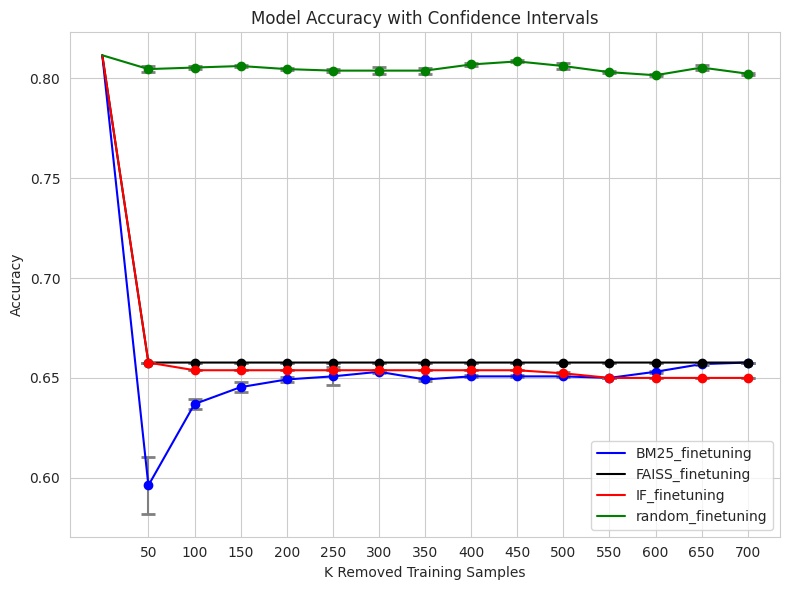

In [16]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")


for module1_name, color in zip(module1_names,colors):
    accuracies = []
    print(module1_name)

    for k_model in k_models:
        print(k_model)
        checkpoints = os.listdir(f"../../output/{module1_name}/{k_model}/")
        num_checkpoints = len(checkpoints)
        model_accuracies = []
        
        for checkpoint in checkpoints[5:]:
            # Load the model
            model_path = f"../../output/{module1_name}/{k_model}/{checkpoint}"
            model = AutoModelForSequenceClassification.from_pretrained(model_path,num_labels = 2).to(DEVICE)
            model.to(DEVICE)
            model.eval()
            
            accuracy = utils.compute_accuracy(model, test_dl, DEVICE)
            model_accuracies.append(accuracy)
        
        accuracies.append(model_accuracies)

    # Convert to numpy array for easier manipulation
    accuracies = np.array(accuracies)

    # Compute mean and standard error for each model
    means = np.mean(accuracies, axis=1)
    std_errors = np.std(accuracies, axis=1) / np.sqrt(num_checkpoints)

    # Plotting
    plt.errorbar(k_models, means, yerr=std_errors, fmt='o', capsize=5, capthick=2, ecolor='gray', color = color)
    plt.plot([0]+k_models, np.hstack([base_model_acc,means]), color = color, label = module1_name)

plt.xlabel('K Removed Training Samples')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Confidence Intervals')
plt.xticks(k_models)
plt.legend()

plt.tight_layout()
#plt.savefig('model_accuracies.png')
plt.show()

BM25_finetuning
50


100
150
200
250
300
350
400
450
500
550
600
650
700
FAISS_finetuning
50
100
150
200
250
300
350
400
450
500
550
600
650
700
IF_finetuning
50
100
150
200
250
300
350
400
450
500
550
600
650
700
random_finetuning
50
100
150
200
250
300
350
400
450
500
550
600
650
700


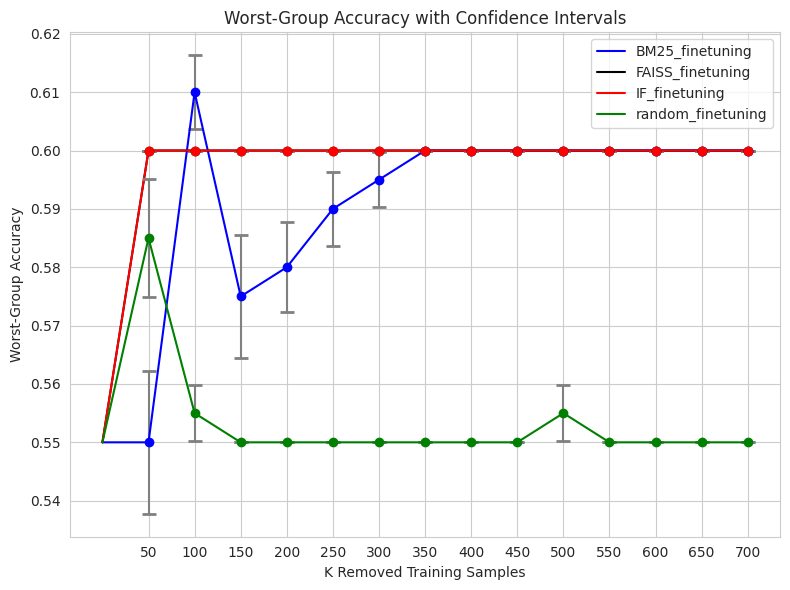

In [17]:
# Worst-Group Accuracies

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

for module1_name,color in zip(module1_names,colors):
    wg_accuracies = []
    print(module1_name)

    for k_model in k_models:
        model_accuracies = []
        checkpoints = os.listdir(f"../../output/{module1_name}/{k_model}/")
        num_checkpoints = len(checkpoints)
        print(k_model)
        
        for checkpoint in checkpoints:
            # Load the model
            model_path = f"../../output/{module1_name}/{k_model}/{checkpoint}"
            model = AutoModelForSequenceClassification.from_pretrained(model_path,num_labels = 2).to(DEVICE)
            model.to(DEVICE)
            
            # Compute accuracy
            accuracy = utils.compute_accuracy(model, wg_test_dl, DEVICE)
            model_accuracies.append(accuracy)
        
        wg_accuracies.append(model_accuracies)

    # Convert to numpy array for easier manipulation
    wg_accuracies = np.array(wg_accuracies)

    # Compute mean and standard error for each model
    means = np.mean(wg_accuracies, axis=1)
    std_errors = np.std(wg_accuracies, axis=1) / np.sqrt(num_checkpoints)

    # Plotting

    plt.errorbar(k_models, means, yerr=std_errors, fmt='o', capsize=5, capthick=2, ecolor='gray',color=color)
    plt.plot([0]+k_models, np.hstack([base_model_acc_wg,means]), color=color, label = module1_name)

plt.xlabel('K Removed Training Samples')
plt.ylabel('Worst-Group Accuracy')
plt.title('Worst-Group Accuracy with Confidence Intervals')
plt.xticks(k_models)
plt.legend()

plt.tight_layout()
#plt.savefig('model_accuracies.png')
plt.show()